In [1]:
import sys

import numpy as np
import xarray as xr
import geopandas as gpd

from odc.geo.gridspec import GridSpec
from odc.geo.geobox import GeoBox
from odc.geo.geom import BoundingBox
from odc.geo.types import xy_

import datacube
dc = datacube.Datacube()

from dea_tools.datahandling import load_reproject

sys.path.insert(1, "/home/jovyan/code/supratidal_forests/data")
from gridspec_96km_tiles import tiles

# load virtual product
import importlib
from datacube.virtual import catalog_from_file
from datacube.virtual import DEFAULT_RESOLVER
catalog = catalog_from_file('../virtual_products/virtual_product_cat_wcf.yaml')

### setup gridspec

In [2]:
# Expanded Extents 96 km tiling grid
gs_c3_expanded = GridSpec(
    crs="EPSG:3577",
    resolution=30,
    tile_shape=(3200, 3200),
    origin=xy_(-4416000, -6912000),
)

In [3]:
# Visualising whole grid
# Set bounding box
c3_bbox = BoundingBox(
    left=-2400000, bottom=-5088000, right=2784000, top=-864000, crs="EPSG:3577"
)

# Convert grid to geopandas polygon dataset covering full C3 grid extent
grid_gdf = gpd.GeoDataFrame.from_features(
    gs_c3_expanded.geojson(bbox=c3_bbox),
    crs="EPSG:4326", # TODO: Raf, why is this crs different to above c3_bbox? This seems problematic. Please investigate
)
grid_gdf.explore()

In [4]:
# User input, select tiles from list
print(tiles)

[(45, 58), (42, 35), (52, 31), (59, 26), (64, 32), (63, 31)]


In [5]:
# Extract GeoBox for specific tile 
bbox = tiles[4]# x51y54
geobox = gs_c3_expanded[bbox]  
geobox.explore()

### load in layers to tidal connectivity model (TCM)

In [6]:
# load in tiles already done from SCF elev and connectivity
geotiff_path = 'SCF_elevation_model_' + 'x' + str(bbox[0]) + 'y' + str(bbox[1]) + '.tif'
supratidal_elevation_model = load_reproject(path=geotiff_path, how=geobox)
# get mask where true is extent of supratidal_elevation_model
supratidal_elevation_model_combine = ~supratidal_elevation_model.isnull().compute()

geotiff_path = 'SCF_connectivity_model_' + 'x' + str(bbox[0]) + 'y' + str(bbox[1]) + '.tif'
costdist_da_norm_invert = load_reproject(path=geotiff_path, how=geobox)
# get mask where true is extent of supratidal_connectivity_model
costdist_da_norm_invert_combine = ~costdist_da_norm_invert.isnull().compute()

In [7]:
TCM = supratidal_elevation_model_combine | costdist_da_norm_invert_combine

### load in other vegetation masks and wofs (i.e. not being considered supratidal and coastal floodplain forests)
- DEA mangroves
- JCU saltmarsh and saltflats
- CEM tidal Flats, Intertidal reefs and Intertidal rocky substratum (2), Mangroves (3), Saltmarsh (4), Intertidal Seagrass (5)
- WOfS

In [8]:
# Load in water from wofs
wofs = dc.load(product="ga_ls_wo_fq_cyear_3", measurements=["frequency"], time = ("2020", "2020"), like=geobox)
# get water class
water = xr.where((wofs.frequency >= 0.2), 1, 0).astype('int8')

# load in DEA mangroves
DEAmangrove = dc.load(product = 'ga_ls_mangrove_cover_cyear_3', time = ("2020", "2020"), like=geobox)
# if no mangroves within AOI, create dummy xr.dataarray
if DEAmangrove.data_vars == {}:
    mangrove = xr.DataArray(np.zeros_like(water), coords=water.coords, dims=water.dims, attrs=water.attrs)
else:
    # get output of mangrove == 1, not mangrove == 0
    mangrove = (DEAmangrove.canopy_cover_class != 255)

# Load in JCU saltmarsh
geotiff_path = '/home/jovyan/gdata1/data/saltmarsh/JCU_Australia-saltmarsh-extent_v1-0.tif'
# load in geotiff again but with identical extent from srtm
saltmarsh = load_reproject(path=geotiff_path, how=geobox)

# Load in JCU saltflat
geotiff_path = '/home/jovyan/gdata1/data/saltmarsh/JCU_Australia-saltflat-extent_v1-0.tif'
# load in geotiff again but with identical extent from srtm
saltflat = load_reproject(path=geotiff_path, how=geobox)

# Load in CEM data
geotiff_path = '/home/jovyan/gdata1/projects/coastal/supratidal_forests/data/CEM_v002/ga_s2ls_coastalecosystems_cyear_3_2021--P1Y_interim_classification_0-0-2.tif'
CEM_data = load_reproject(path=geotiff_path, how=geobox)
CEM = ~CEM_data.isnull()

In [9]:
# combine masks for LCP, where 1 indicates aquatic features to start calculating LCP from, 0 are areas that will be given a LCP value

# change to zero being where these are present, and 1 being where they are not present

aquatic = xr.where((water == True) | (mangrove == True) | (saltmarsh == True) | 
                   (saltflat == True) | (CEM == True) , 0, 1).astype('bool').squeeze('time') # TODO: Raf, investigate issue sometimes here with time dim (i.e. tile 45, 57, also for 44, 36) - probably need to write a if else statement to check and squeeze time dim if it exists
# load_reproject is dask arrays, change to dataarray
aquatic = aquatic.compute()

### TCM + other veg mask

In [10]:
TCM_veg_mask = TCM & aquatic

### load woody cover product

In [11]:
# Set up woody cover model #

# load in vp woody cover
sys.path.insert(2, '../virtual_products') 
# The dictionary which datacube uses to understand (resolve) the different virtual product functionality
# Need to add any aggregations for the VP you're using

# Get location of transformation
aggregation = "best_pixel_gmad"
agg_loc = importlib.import_module(aggregation)
agg_class = aggregation.split('.')[-1]

DEFAULT_RESOLVER.register('aggregate', agg_class, getattr(agg_loc, agg_class) )

# Need to add any tranformations for the VP you're using
# Get location of transformation
transformation = "woody_cover"
trans_loc = importlib.import_module(transformation)
trans_class = transformation.split('.')[-1]

DEFAULT_RESOLVER.register('transform', trans_class, getattr(trans_loc, trans_class) )

In [12]:
# NOTE: bug in using geobox with virtual products. does not work even with odc.geobox.compat
# working as below, but very clunky way of getting this to work

# Extract bounds for x and y as well as time from the dataset
x_bounds = (wofs.x.min().item(), wofs.x.max().item())
y_bounds = (wofs.y.min().item(), wofs.y.max().item())
time_bounds = (str(wofs.time.dt.year[0].item()), str(wofs.time.dt.year[-1].item()))

# Construct the query dictionary with CRS
query = {
    'x': x_bounds,
    'y': y_bounds,
    'time': time_bounds,
    'crs': 'EPSG:3577'
}

In [13]:
%%time
# load woody_cover vp
product = catalog['woody_cover']
woody_cover_vp = product.load(dc, resampling="bilinear", **query)
woody_cover = woody_cover_vp.woody_cover

/env/lib/python3.10/site-packages/datacube/virtual/transformations.py:440: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  return time.astype('datetime64[Y]')
/env/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


CPU times: user 46.2 s, sys: 2.43 s, total: 48.6 s
Wall time: 1min 7s


### generate SCF woody model

In [14]:
# remove outside extent of TCM+veg mask (make np.nan)
SCF_woody_model = xr.where(TCM_veg_mask == 1, woody_cover.values, np.nan)

PosixPath('SCF_woody_model_x64y32.tif')

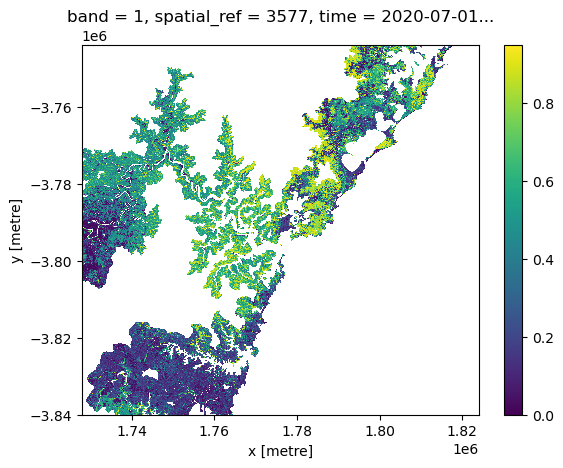

In [15]:
SCF_woody_model.plot()
TCM_export = xr.where(TCM == 1, 1, np.nan)
TCM_export.odc.write_cog('TCM_' + 'x' + str(bbox[0]) + 'y' + str(bbox[1]) + '.tif', overwrite=True)
SCF_woody_model.odc.write_cog('SCF_woody_model_' + 'x' + str(bbox[0]) + 'y' + str(bbox[1]) + '.tif', overwrite=True)